# Using KNN to reclasify missing industry entries
Some entries have industries missing. The assumption is, if there are 10 or so tech industries and one is unclassifed, then it is likely a tech industry company

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# to ensure displayed tables don't truncate columns
pd.set_option('display.max_columns', None) 

In [2]:
leases = pd.read_csv('../Datasets/focused_lease.csv')

# Initial exploration
Checking out what leases latitude and longitude looks like

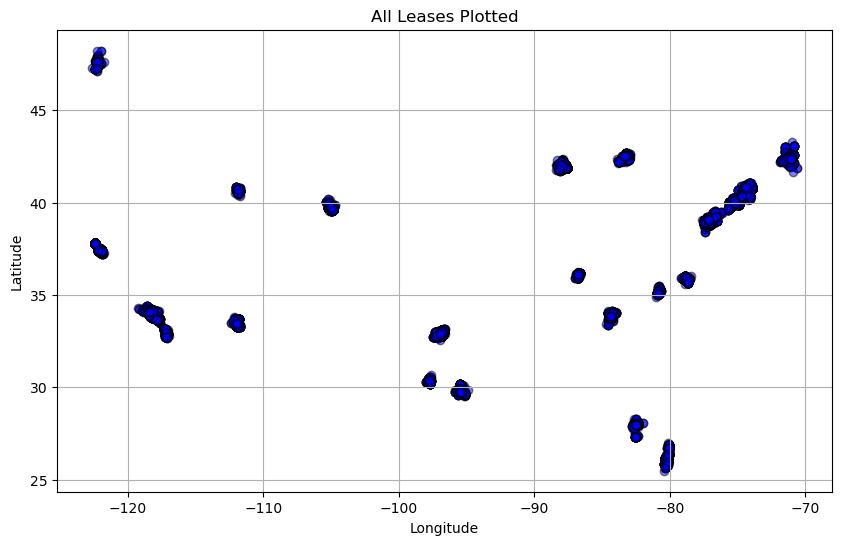

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(leases['lng'], leases['lat'], alpha=0.5, c='blue', edgecolors='k')

# Labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("All Leases Plotted")
plt.grid(True)

# Show plot
plt.show()

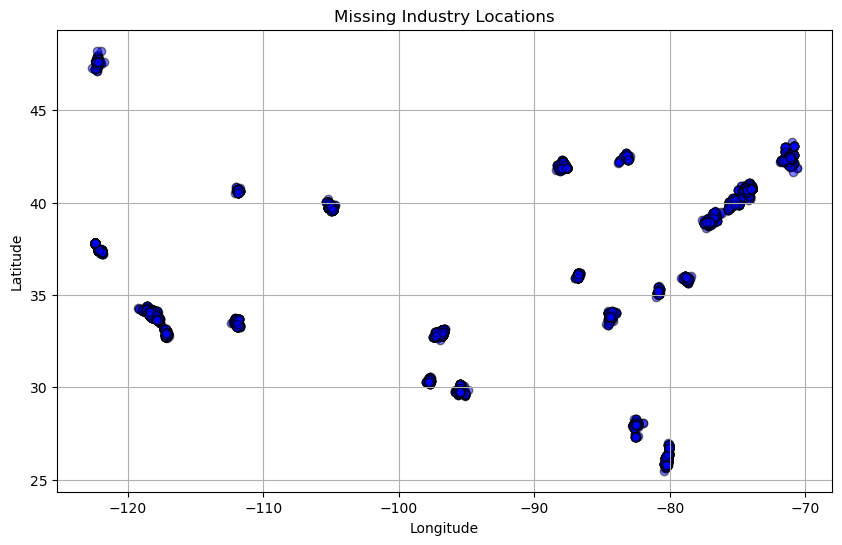

In [4]:
missing_industries = leases[leases['internal_industry'].isna()]

plt.figure(figsize=(10, 6))
plt.scatter(missing_industries['lng'], missing_industries['lat'], alpha=0.5, c='blue', edgecolors='k')

# Labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Missing Industry Locations")
plt.grid(True)

# Show plot
plt.show()


# Founding Unfounded Assumptions
We are going to now KNN to add extra entries that would've been unsuable. We will compare side by side what impacts the assumptions made.

In [5]:
def euclidean_distance(lat_x, long_x, lat_y, long_y, cutoff=50):
    """
    Computes the Euclidean distance (approximate) between two geographical points.
    If the distance exceeds the cutoff (default: 50 miles), return None.
    """
    # Convert degrees to radians
    lat_x, long_x, lat_y, long_y = map(np.radians, [lat_x, long_x, lat_y, long_y])
    
    # Approximate radius of Earth in miles
    R = 3958.8  

    # Compute differences
    delta_lat = lat_y - lat_x
    delta_long = long_y - long_x

    # Approximate Euclidean distance (ignoring Earth's curvature)
    distance = R * np.sqrt(delta_lat**2 + delta_long**2)

    # Apply cutoff
    if distance > cutoff:
        return None  # Cutoff exceeded
    return distance


In [ ]:
k = 11
min_k = 5

amputations = pd.DataFrame(columns=['chosen_industry', 'industries_looked_at'])
reconstruced_leases = leases
print("leases null industries before: ", leases['internal_industry'].isnull().sum())

i=0
for row in missing_industries.itertuples(index=False):

    state_leases = leases[(leases['state'] == row.state) & leases['internal_industry'].notna()]
    distances = []

    # Compute distances for all leases in the same state
    for lease in state_leases.itertuples(index=False):
        dist = euclidean_distance(row.lat, row.lng, lease.lat, lease.lng, cutoff=150)
        # print(dist)
        if dist is not None:  # Ignore distances beyond cutoff
            distances.append((dist, lease.internal_industry))

    if len(distances) < min_k:
        continue

    k_nearest = sorted(distances, key=lambda x: x[0])[:k]

    if k_nearest:
        industries = [industry for _, industry in k_nearest]
        most_common_industry = Counter(industries).most_common(1)[0][0]

        reconstruced_leases.loc[leases['index'] == row.index, 'internal_industry'] = most_common_industry


        amputations = pd.concat([amputations, pd.DataFrame([{
            'chosen_industry': most_common_industry,
            'industries_looked_at': industries,
        }])], ignore_index=True)

    # print(i)
    i+=1

print("leases null industries after: ", reconstruced_leases['internal_industry'].isnull().sum())
reconstruced_leases.to_csv('../Datasets/reconstructed_leases.csv', index=False, )
print(f'reconstruced: {amputations.shape[0]} rows and {amputations.shape[1]} columns')
amputations







leases null industries before:  12575
leases null industries after:  0
reconstruced: 12575 rows and 2 columns


,chosen_industry,industries_looked_at
0,Retail,"[Financial Services and Insurance, Manufacturi..."
1,Retail,"[Financial Services and Insurance, Retail, Man..."
2,"Technology, Advertising, Media, and Information","[Technology, Advertising, Media, and Informati..."
3,Financial Services and Insurance,"[Legal Services, Education, Coworking and Exec..."
4,"Technology, Advertising, Media, and Information","[Healthcare, Financial Services and Insurance,..."
...,...,...
12570,"Technology, Advertising, Media, and Information","[Technology, Advertising, Media, and Informati..."
12571,"Technology, Advertising, Media, and Information","[Technology, Advertising, Media, and Informati..."
12572,TBD,"[TBD, Legal Services, TBD, TBD, TBD, TBD, Fina..."
12573,"Technology, Advertising, Media, and Information","[Construction, Engineering and Architecture, R..."


In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML




def animate_knn_imputation(missing_industries, leases, k=11, cutoff=150):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Initialize scatter plots with proper array types
    existing = ax.scatter([], [], c='gray', label='Existing Leases', alpha=0.5)
    missing = ax.scatter(np.empty((0,2)), [], c='red', s=100, marker='x', label='Missing Points')  # Fix 1: Initialize with empty array
    neighbors = ax.scatter([], [], c='blue', s=150, edgecolors='black', label='Neighbors')
    
    def update(frame):
        row = missing_industries.iloc[frame]
        ax.set_title(f"Imputing point {frame+1}/{len(missing_industries)} - {row.state}")
        
        state_leases = leases[(leases['state'] == row.state) & leases['internal_industry'].notna()]
        
        # Convert to NumPy arrays
        existing_data = np.array(state_leases[['lng', 'lat']])  # Fix 2: Convert to array
        missing_data = np.array([[row.lng, row.lat]])  # Fix 3: Use 2D array
        
        # Calculate distances with array conversion
        distances = []
        for lease in state_leases.itertuples(index=False):
            dist = euclidean_distance(row.lat, row.lng, lease.lat, lease.lng, cutoff=cutoff)
            if dist is not None:
                distances.append((dist, lease.internal_industry, lease.lat, lease.lng))
        
        k_nearest = sorted(distances, key=lambda x: x[0])[:k]
        neighbor_data = np.array([[x[3], x[2]] for x in k_nearest]) if k_nearest else np.empty((0,2))

        # Update plots with array transposes
        existing.set_offsets(existing_data)
        missing.set_offsets(missing_data)
        neighbors.set_offsets(neighbor_data)
        
        return existing, missing, neighbors

    # Store animation reference
    ani = FuncAnimation(
        fig, 
        update, 
        frames=len(missing_industries),
        interval=500,
        blit=False,
        cache_frame_data=False  # Fix 4: Prevent frame caching issues
    )
    
    plt.legend()
    plt.close()
    # For Jupyter
    from IPython.display import HTML
    HTML(ani.to_jshtml())

    # For Streamlit
    import streamlit.components.v1 as components
    components.html(ani.to_jshtml(), height=1000)
    return HTML(ani.to_jshtml())






<Axes: xlabel='chosen_industry'>

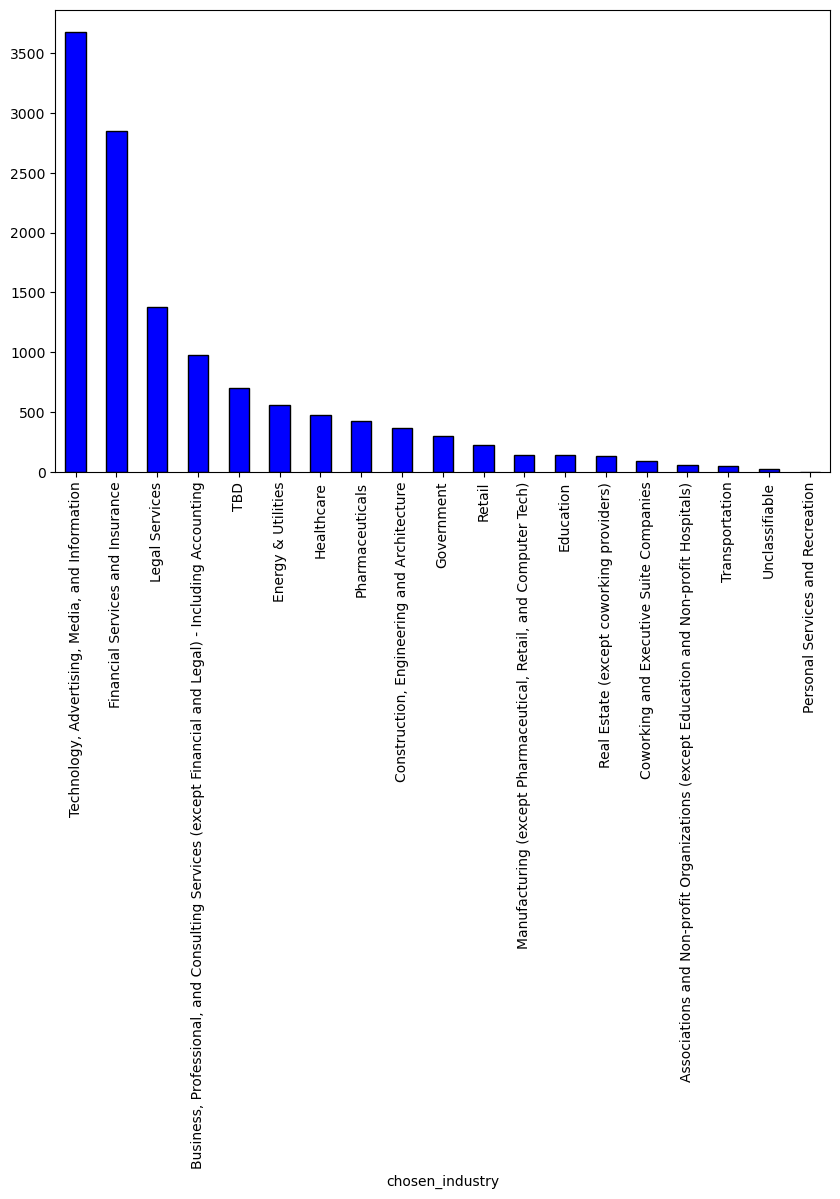

In [ ]:
amputations['chosen_industry'].value_counts().plot(kind='bar', figsize=(10, 6), color='blue', edgecolor='k')

In [ ]:
ghg = pd.read_csv('./amputation_leases.csv')
ghg['internal_industry'].isnull().sum()


0